In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn

import gymnax
import equinox as eqx
import optax

import time
import matplotlib.pyplot as plt

from helpers import dataloader, rollout_parallel
from ode import train_dynamics
from models import NeuralNetwork, NeuralODE
from helpers import rollout_parallel


In [2]:
def rollout_on_real_sys(key, params, model_static, env_params, n_trajectories):
    # Rollout 
    keys_rollout = jr.split(key, n_trajectories)
    obss, actionss, rewardss, _, _= rollout_parallel(keys_rollout, params, model_static, env_params)
    # Return data
    data = jnp.concatenate([obss, jnp.expand_dims(actionss, axis=-1)], axis=2)
    # Get length of rollout
    ts = jnp.linspace(0, env_params.dt * env_params.max_steps_in_episode, env_params.max_steps_in_episode)

    return ts, data, rewardss

In [3]:
SEED = 0
key_policy, key_rollout, key_ODE = jr.split(jr.PRNGKey(SEED), 3)
len_strat = (0.15, )

# Generate rollout on policy
policy = NeuralNetwork(input_size=3 , output_size=3, width_size=50, depth=1, key=key_policy)
policy_params, policy_static = eqx.partition(policy, eqx.is_inexact_array)
_, env_params = gymnax.make("Pendulum-v1")
n_trajectories = 100
ts, data, reward = rollout_on_real_sys(key_rollout, policy_params, policy_static, env_params, n_trajectories)

# Train ODE with rolllout data
ODE_model = NeuralODE(4, 3, width_size=20, depth=4, key=key_ODE)
ODE_params, ODE_static = eqx.partition(ODE_model, eqx.is_inexact_array)
ys, losses, ODE_model = train_dynamics(data, ts, ODE_params, ODE_static, key=key_ODE,
                                       length_strategy=len_strat)

Step: 0, Loss: 4.897485256195068, Computation time: 9.187398910522461
Step: 100, Loss: 3.924910545349121, Computation time: 0.0186617374420166
Step: 200, Loss: 4.842648983001709, Computation time: 0.04085683822631836
Step: 300, Loss: 3.5778653621673584, Computation time: 0.035570621490478516
Step: 400, Loss: 2.400277853012085, Computation time: 0.030559539794921875
Step: 499, Loss: 2.9926962852478027, Computation time: 0.03443098068237305


(3,)
(200,)


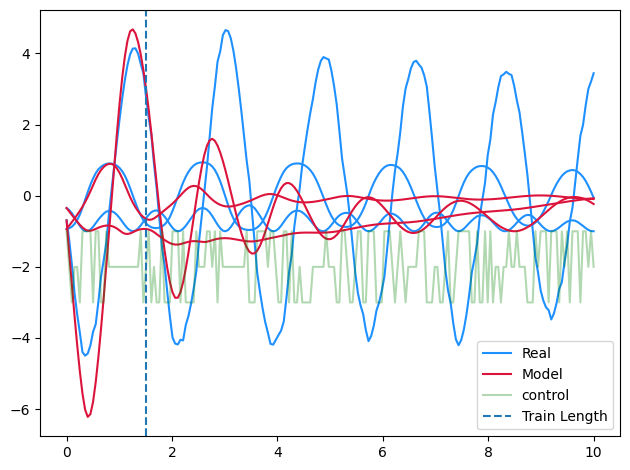

In [5]:
y0 = data[0, 0, :-1]
us = data[0, :, -1]

print(y0.shape)
print(us.shape)
plt.plot(ts, data[0, :, 0], c="dodgerblue", label="Real")
plt.plot(ts, data[0, :, 1], c="dodgerblue")
plt.plot(ts, data[0, :, 2], c="dodgerblue")

model_y = ODE_model(ts, y0, us)

plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
plt.plot(ts, model_y[:, 1], c="crimson")
plt.plot(ts, model_y[:, 2], c="crimson")

plt.plot(ts, us - 2, c="green", alpha=0.3, label='control')
plt.axvline(ts[-1] * len_strat[0], linestyle='--', label='Train Length')

plt.legend()
plt.tight_layout()

plt.show()

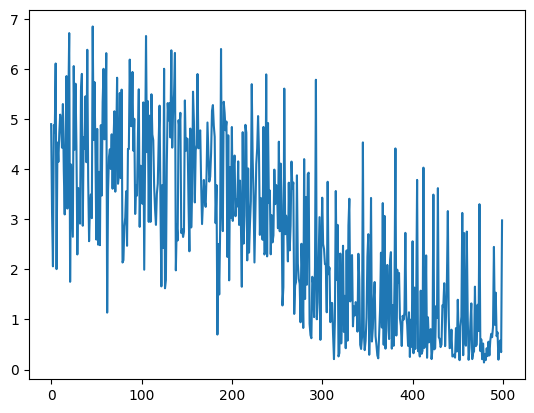

In [ ]:
plt.plot(losses)